# death_predictions_gam


## Usando modelos de Séries Temporais para prever mortes no Brasil

Vamos tentar modelar o número de mortes no Brasil usando alguns modelos de séries temporais modernos.

Começamos importando as bibliotecas necessárias. Condensamos boa parte do código no script `core.py`, para facilitar a utilização desse notebook.

In [1]:
# importing core 
# aqui empacotamos as funções que dá pra achar no código do Kevin Systrom
from core import load_data, load_johns_hopkins_data, estimate_gam, fit_gam

# imports básicos
import numpy as np
import pandas as pd
from datetime import timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

# modelos
from pygam import GammaGAM, PoissonGAM, s, l
from sklearn.utils import resample
from scipy.stats import dirichlet
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

# para plots com uma melhor resolução
%config InlineBackend.figure_format = 'retina'

# style of plot
plt.style.use('bmh')


Bad key "axes.titlelocation" on line 298 in
/Users/guilherme.marmerola/Documents/Repositories/realtime_r0_brazil/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Leitura dos dados

Usamos o [repositório do Wesley Cota](https://github.com/wcota/covid19br) para pegar os dados mais atualizados por estado. 

In [2]:
### reading data ###

# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

# lendo do repositório da johns hopkins
country_df = load_johns_hopkins_data()

# tratamento de números inválidos
country_df = country_df.clip(lower=0)
#country_df[country_df < 0] = np.nan
#country_df = country_df.groupby('country').fillna(method='ffill')

## Generalized Additive Models

Usamos a biblioteca `pygam`, que implementa Modelos Generalizados Aditivos (GAMs), modelos bastante expressivos que usam B-splines penalizadas como *feature functions*, permitindo-os capturar relações não lineares. No nosso caso, como estamos modelando séries temporais, podemos enxergar a expressividade do modelo como memória: quanto mais expressivo o modelo, menos memória ele terá, e usará informação mais recente. GAMs estão em linha com [melhores práticas de previsão de séries temporais](https://peerj.com/preprints/3190/) por conta da sua flexibilidade e expressividade.

Outro benefício de GAMs é permitir a modelagem de distribuições de erro não gaussianas. No nosso caso, isto é importante: como estamos modelando número de mortes, uma distribuição normal para o erro não deve funcionar já que não podemos admitir valores menores que 0. Em geral, a literatura (inclusive a epidemiológica) sugere o uso de uma distribuição *Poisson*. 

### Ajuste

Como GAMs são modelos expressivos, estabilizamos o modelo usando um procedimento de Bagging (Bootstrap Aggregating) modificado. Ao invés de utilizar reamostragem com reposição comum, mantemos todos os datapoints mas ponderamos seu peso na otimização (`weights`) com amostras de uma distribuição Dirichlet com parametrização uniforme. 

Tal procedimento é chamado de [*bayesian (smooth) bootstrap*](https://projecteuclid.org/euclid.aos/1176345338) e cria estimativas de boostrap mais suaves, o que é importante quando temos poucas observações (como é o caso). Assim, ao mesmo tempo, temos uma aproximação da incerteza do modelo e reduzimos *overfitting*. 

Abaixo mostramos uma função para ajustar a GAM, implementando o smooth boostrap:

In [3]:
def fit_gam(series, n_splines=25, algo=PoissonGAM, n_bootstrap=100):
    
    X = np.arange(series.shape[0])
    y = series.values

    # running GAM in bootstrap
    bootstrap = []
    for _ in range(n_bootstrap):

        weights = dirichlet([1] * series.shape[0]).rvs(1)

        gam = algo(s(0, n_splines) + l(0))
        gam.fit(X, y, weights=weights[0])

        bootstrap.append(gam)

    return bootstrap

#### Encontrando `n_splines`

Um hiperparâmetro importante para GAMs é o `n_splines`, o número de splines que vão ser usadas. Quanto maior esse número, mais expressivo será o modelo, podendo ajustar padrões mais não-lineares, mas ao mesmo tempo aumentando o risco de *overfitting*. Dessa forma, antes de ajustar o modelo aos dados do Brasil, vamos este hiperparâmetro `n_splines`, usando um esquema de validação com outros países.

Abaixo criamos uma função para avaliar uma configuração de `n_splines` em países selecionados. Usamos como métrica de validação o [MASE (Mean Absolute Scaled Error)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), que representa a razão entre o erro do nosso modelo e o erro de um modelo simples (baseline), que neste caso vamos escolher como um modelo que prevê a repetição do valor do dia anterior. 

Dessa forma, se o MASE for menor que 1, quer dizer que nosso modelo ganha de um que repete o valor do dia anterior como previsão. A validação cria um dataset de teste consistindo dos últimos `N_DAYS_TEST` dias mais recentes e um dataset de treino excluindo esses dias.

In [4]:
# número de dias para testar
N_DAYS_TEST = 3.0

# lista de países
country_list = ['Argentina','Australia','Korea, South',
                'Italy','Spain','France','United Kingdom',
                'Portugal','US','Germany']

# data do test
test_date = country_df.index.get_level_values(1).max() - timedelta(N_DAYS_TEST)

train = country_df.loc[country_list].loc[lambda x: x.index.get_level_values(1) < test_date]['deaths_new'].dropna()
test = country_df.loc[country_list].loc[lambda x: x.index.get_level_values(1) >= test_date]['deaths_new'].dropna()

In [5]:
# função para avaliar resultados nos países
def evaluate_hypeparameter(n_splines, n_bootstrap=10):
    
    # for numerical reasons 
    epsilon = 10
    
    # lista de países
    countries = train.index.get_level_values(0).unique()

    # inicializando lista de erros
    error_list = []

    # loop para cada país
    for country in countries:
        
        # separando treino e teste para o país específico
        temp_train = train.loc[country] + epsilon
        temp_test = test.loc[country] 

        # ajustando
        bootstrap = fit_gam(temp_train, n_splines=n_splines, n_bootstrap=20)

        # grid para o teste
        test_grid = (temp_test.index - temp_train.index.min()).days.values

        # prevendo
        preds = pd.DataFrame([m.predict(test_grid) - epsilon for m in bootstrap]).T
        mean_preds = preds.mean(axis=1)

        # comparando e salvando
        baseline_pred = temp_test.shift(1).fillna(temp_train.iloc[-1])
        error_baseline = mean_absolute_error(temp_test, baseline_pred)
        error = mean_absolute_error(temp_test, mean_preds)
        error_list.append(error/error_baseline)
        
        #error = mean_squared_log_error(temp_test, mean_preds)
        #error_list.append(error)

    return pd.DataFrame(error_list, index=countries)

Executamos a função para avaliar um intervalo grande `grid_nsplines` para o nosso hiperparâmetro.

In [6]:
# criando grid para número de splines
grid_nsplines = np.arange(4, 40, 2)

# lista de resultados
results_list = []

# loop para cada elemento do grid
for n_splines in grid_nsplines:
    result = evaluate_hypeparameter(n_splines)
    results_list.append(result)
    
# df with results
results_df = pd.concat(results_list, axis=1)
results_df.columns = grid_nsplines

# series with avg result
avg_result = results_df.mean()

A melhor escolha de `n_splines` fica guardada na variável `best_hp`.

In [7]:
# melhor hiperparâmetro
best_hp = avg_result.idxmin()
best_hp_result = avg_result.min()

Os resultados mostram que nosso modelo é razoavelmente melhor do que repetir o valor do dia anterior. Também vemos o melhor valor de `n_splines` abaixo:

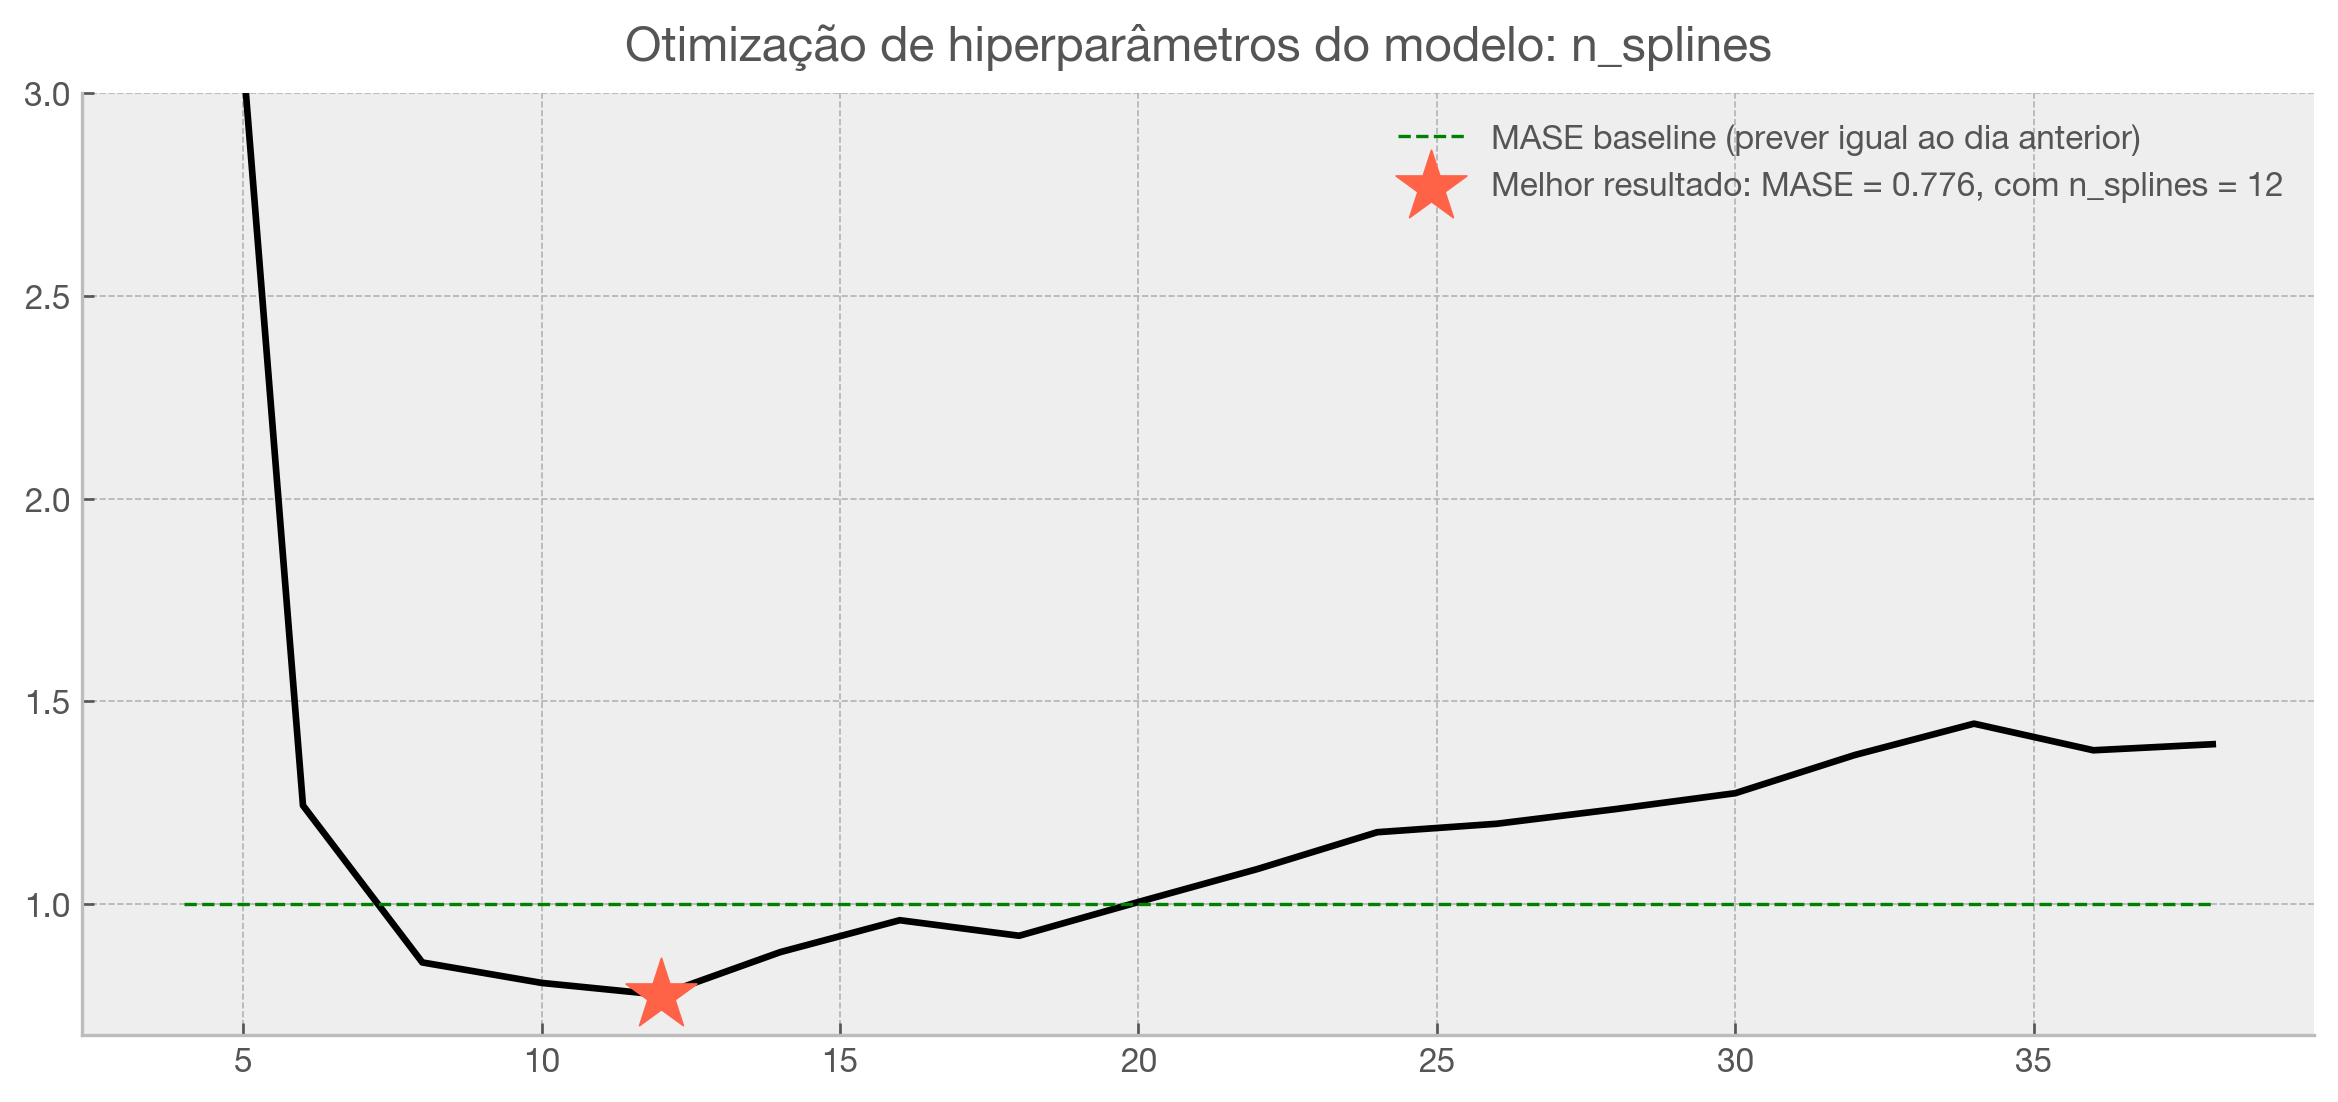

In [8]:
# visualizando resultados #

# opening figure
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)

# plotting mean predictions
plt.scatter([best_hp],[best_hp_result], color='tomato', s=500, zorder=10, marker='*',
            label= f'Melhor resultado: MASE = {np.round(best_hp_result,3)}, com n_splines = {best_hp}')
plt.plot(avg_result.index, avg_result, 'k')
plt.plot([grid_nsplines.min(), grid_nsplines.max()], [1,1], 'g--', linewidth=1, label='MASE baseline (prever igual ao dia anterior)')

# more formatting
plt.title('Otimização de hiperparâmetros do modelo: n_splines');
plt.ylim(best_hp_result - 0.1, 3)
plt.legend();

### Série temporal

Começamos separando uma série temporal de mortes para o Brasil. Modificando `STATE_NAME` e a linha `[['deaths_new']]` é possível modelar outras séries (e.g. casos confirmados) e em outras quebras (e.g. estado de São Paulo).

In [9]:
# nome do estado
STATE_NAME = 'Brazil'

# filtrando
series = (state_df
          #country_df
          .loc[STATE_NAME]
          [['deaths_new']]
          .dropna())

Ajustamos o modelo usando a parametrização ótima que descobrimos.

In [10]:
# ajuste
bootstrap = fit_gam(series, n_splines=best_hp, n_bootstrap=200)

### Previsão

Fazemos a previsão para um horizonte determinado (`HORIZON`). Como fizemos o procidimento de bootstrap teremos `N_MODELS` previsões, onde podemos tirar o valor esperado (média das previsões dos modelos individuais) e intervalos de previsão (percentis das previsões dos modelos individuais).

In [11]:
# prediction horizon in days
HORIZON = 7

# prediction grid
grid = np.arange(series.shape[0] + HORIZON)

# date grid
ini_date = series.index.min()
grid_dates = [ini_date + timedelta(float(i)) for i in grid]

# predicting
preds = pd.DataFrame([m.predict(grid) for m in bootstrap]).T
preds.index = grid_dates

# getting mean prediction
mean_preds = preds.mean(axis=1)

### Resultados

Vamos visualizar os resultados.

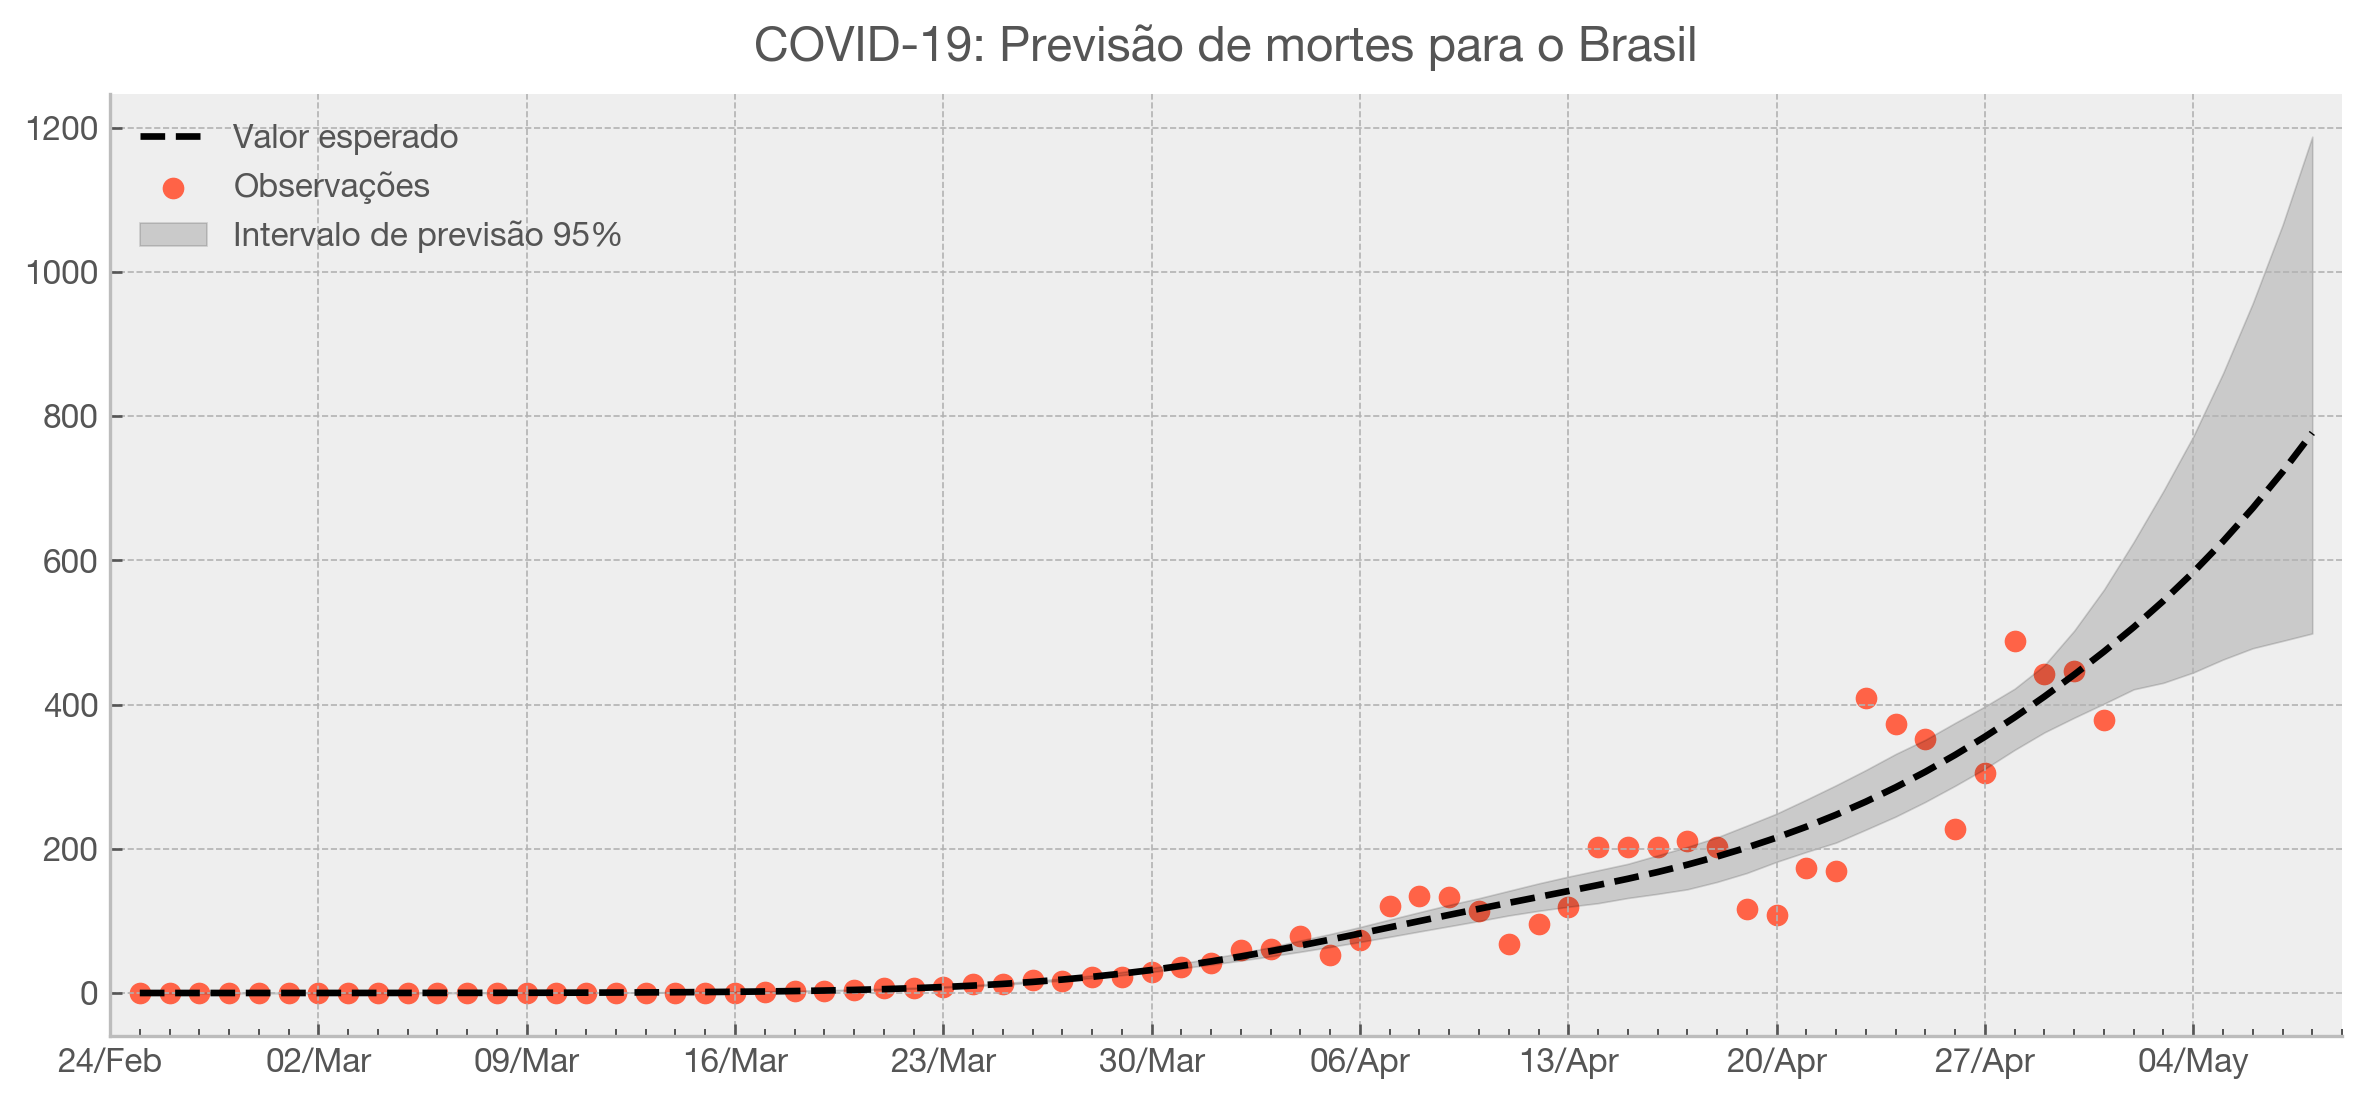

In [12]:
# opening figure
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)

# plotting cases
plt.scatter(series.index, series, color='tomato', label='Observações')

# plotting mean predictions
plt.plot(mean_preds.index, mean_preds, 'k--', label='Valor esperado')

# plotting posterior samples
#plt.plot(preds.index, preds, 'k', alpha=0.03)

# plotting confidence interval
plt.fill_between(preds.index, 
                 preds.quantile(0.025, axis=1), 
                 preds.quantile(0.975, axis=1),
                 alpha=0.15, color='black',
                 label='Intervalo de previsão 95%')

# setting locators
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

# more formatting
plt.title('COVID-19: Previsão de mortes para o Brasil');
plt.xlim(preds.index.min() - timedelta(1.0), 
         preds.index.max() + timedelta(1.0))
plt.legend(loc='upper left');

##### Gerando tabela com resultados

In [13]:
# table with results
results = (pd.concat([series, 
                      mean_preds, 
                      preds.quantile(0.10, axis=1), 
                      preds.quantile(0.90, axis=1)],
                     axis=1)
           .reset_index()
           .rename(columns={0:'expected',0.1:'P10',0.9:'P90','index':'date'})
           .round(2)
          )
results

,date,deaths_new,expected,P10,P90
0,2020-02-25,0.0,0.01,0.01,0.02
1,2020-02-26,0.0,0.02,0.01,0.02
2,2020-02-27,0.0,0.02,0.01,0.03
3,2020-02-28,0.0,0.03,0.02,0.04
4,2020-02-29,0.0,0.03,0.02,0.04
...,...,...,...,...,...
69,2020-05-04,NaN,583.61,479.77,669.38
70,2020-05-05,NaN,626.38,503.44,736.11
71,2020-05-06,NaN,672.65,525.49,809.50
72,2020-05-07,NaN,722.72,549.41,890.23
